In [1]:
### import modules
import numpy as np
import seaborn as sns
from graspologic.plot import heatmap
import matplotlib.pyplot as plt
from utils import calculate_dissim, laplacian_dissim
from myst_nb import glue

# Matched Networks

We will use the [one sample discriminability](https://mgc.neurodata.io/api/generated/hyppo.discrim.discrimonesample) test from [hyppo](https://mgc.neurodata.io/index.html) to assess how well each kernel detects dissimilarity between labels. The discriminability index is a measure of whether a data acquisition method is more discriminable than others, and the one sample test determines whether the discriminability of the sample differs from random chance {cite}`bridgeford2019discrim`. 

First, we load in 32 networks that were generated from MRI scans of mice brains, provided by [Graspologic](https://microsoft.github.io/graspologic/latest/index.html). The mice came from 4 different genotypes, and there were 8 mice per genotype. 

## Load Data

In [2]:
# HIDE CELL

# load the full mouse dataset
from graspologic.datasets import load_mice
mice = load_mice()

# Stack all adjacency matrices in a 3D numpy array
graphs = np.array(mice.graphs)
print(graphs.shape)

# initialize labels
labels = {}
for i in np.arange(0, 332):
    labels[i] = i

(32, 332, 332)


Now we generate dissimilarity matrices based on each of the kernels outlined in the {doc}`kernels<kernels.ipynb>` notebook in the Introduction. Note that by default, we only show results for the Density kernel, the Edge weight kernel (using the $L^1$-norm), the Laplacian spectral kernel, and the Omnibus embedding kernel, but all results can be expanded for viewing. 

Every dissimilarity matrix is visualized by the [heatmap](https://microsoft.github.io/graspologic/latest/reference/reference/plotting.html#heatmap) function from Graspologic, and are sorted by their labels. We also normalize the dissimilarity matrix by dividing it by its maximum value, scaling the matrix from 0 to 1.

## Global Properties

### Density

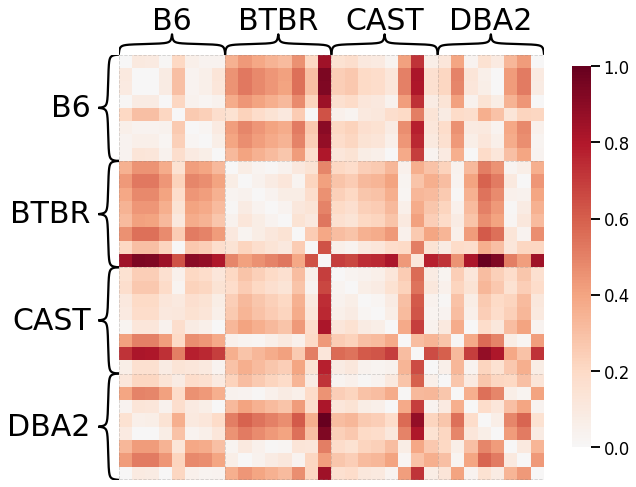

In [3]:
# HIDE CODE
scaled_density_dissim = calculate_dissim(graphs, method="density", norm=None, normalize=True)

ax = heatmap(scaled_density_dissim, context="talk", inner_hier_labels=mice.labels)
ax.figure.set_facecolor('w')

### Average Edge Weight

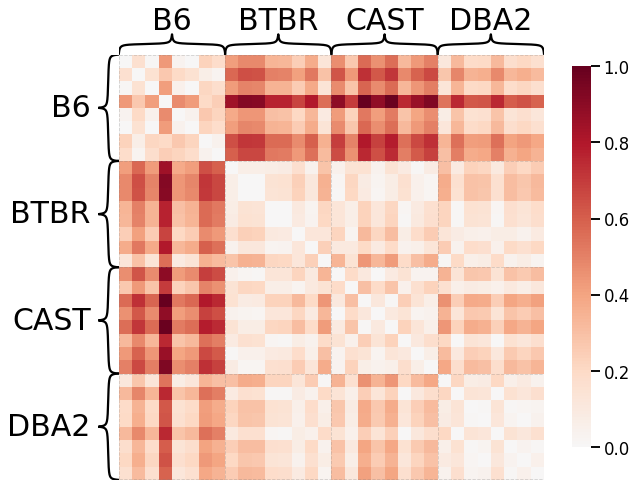

In [4]:
# HIDE CELL
scaled_avgedgeweight_dissim = calculate_dissim(graphs, method="avgedgeweight", norm=None, normalize=True)

ax = heatmap(scaled_avgedgeweight_dissim, context="talk", inner_hier_labels=mice.labels)
ax.figure.set_facecolor('w')

### Average of the Adjacency Matrix

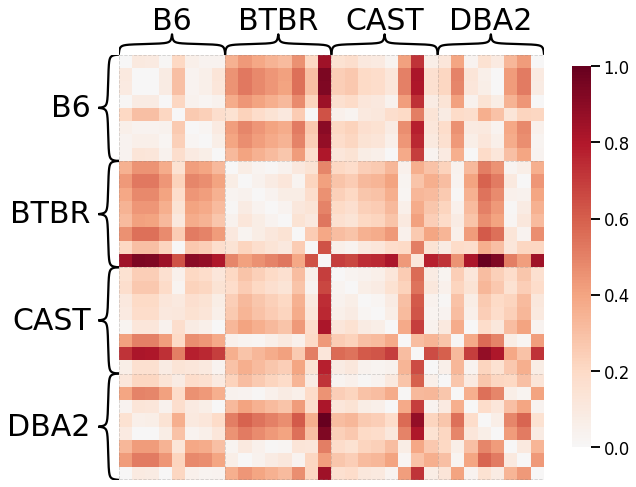

In [5]:
# HIDE CELL
scaled_avgadjmat_dissim = calculate_dissim(graphs, method="avgadjmatrix", norm=None, normalize=True)

ax = heatmap(scaled_avgadjmat_dissim, context="talk", inner_hier_labels=mice.labels)
ax.figure.set_facecolor('w')

### Laplacian Spectral Distance
Each network is transformed using pass-to-ranks, and the L2 norm of the difference between the sorted eigenspecta is calculated.

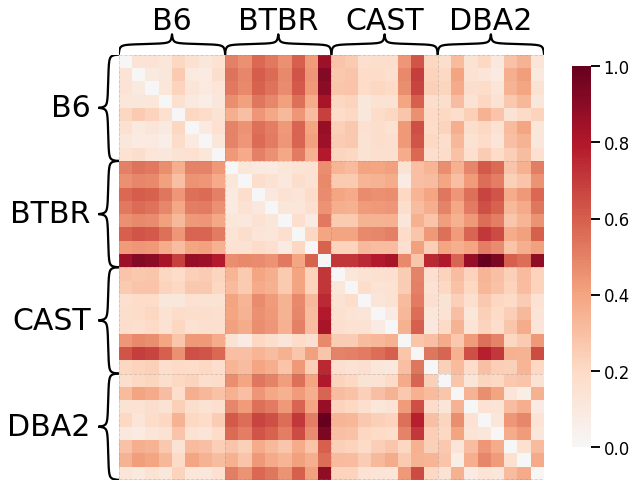

In [6]:
# HIDE CODE
scaled_lap_dissim = laplacian_dissim(graphs, transform='pass-to-ranks', metric='l2', normalize=True)

ax = heatmap(scaled_lap_dissim, context="talk", inner_hier_labels=mice.labels)
ax.figure.set_facecolor('w')

## Node-wise Properties

### Node Degrees - L1 Norm

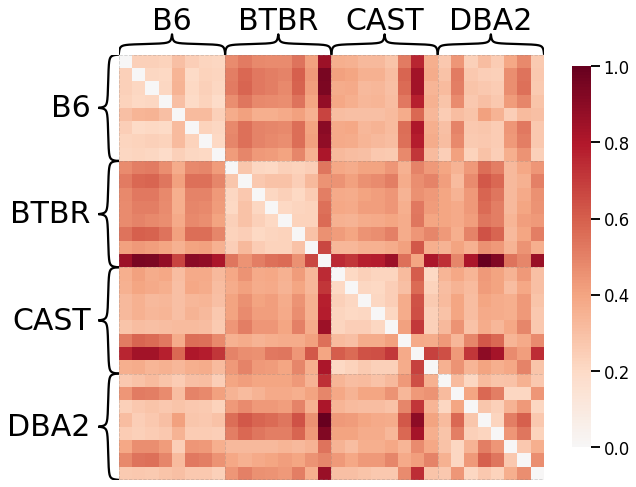

In [7]:
# HIDE CELL
scaled_nodedeg_dissim_l1 = calculate_dissim(graphs, method="degree", norm="l1", normalize=True)

ax = heatmap(scaled_nodedeg_dissim_l1, context="talk", inner_hier_labels=mice.labels)
ax.figure.set_facecolor('w')

### Node Degrees - L2 Norm

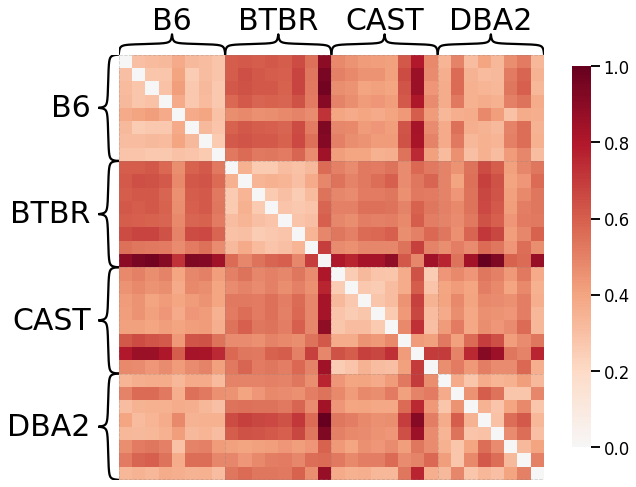

In [8]:
# HIDE CELL
scaled_nodedeg_dissim_l2 = calculate_dissim(graphs, method="degree", norm="l2", normalize=True)

ax = heatmap(scaled_nodedeg_dissim_l2, context="talk", inner_hier_labels=mice.labels)
ax.figure.set_facecolor('w')

### Node Strength - L1 Norm

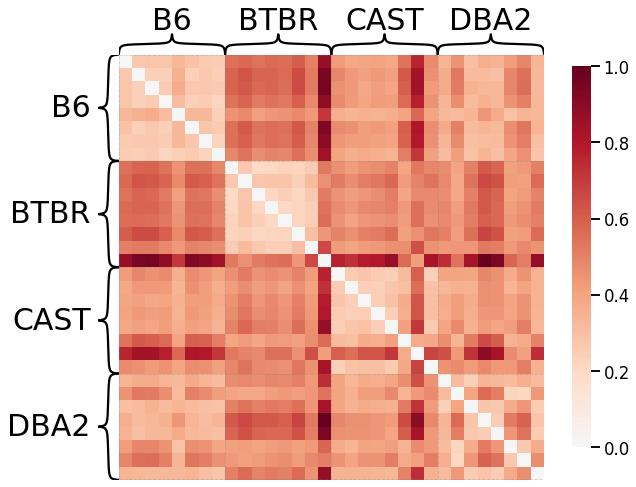

In [9]:
# HIDE CELL
scaled_nodestr_dissim_l1 = calculate_dissim(graphs, method="strength", norm="l1", normalize=True)

ax = heatmap(scaled_nodestr_dissim_l1, context="talk", inner_hier_labels=mice.labels)
ax.figure.set_facecolor('w')

### Node Strength - L2 Norm

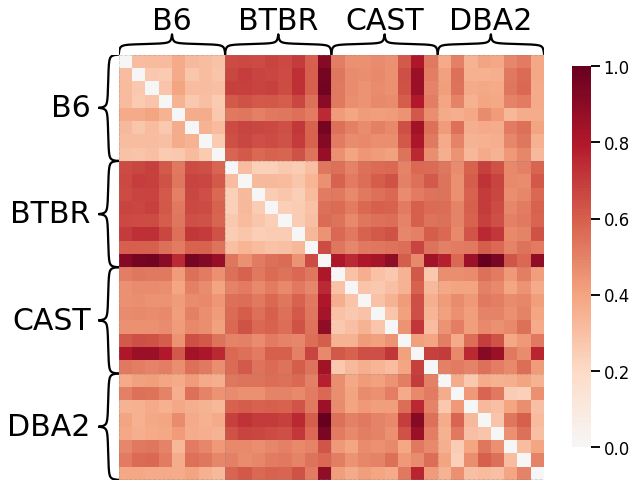

In [10]:
# HIDE CELL
scaled_nodestr_dissim_l2 = calculate_dissim(graphs, method="strength", norm="l2", normalize=True)

ax = heatmap(scaled_nodestr_dissim_l2, context="talk", inner_hier_labels=mice.labels)
ax.figure.set_facecolor('w')

## Edge-wise Properties

### Edge weights - L1 Norm

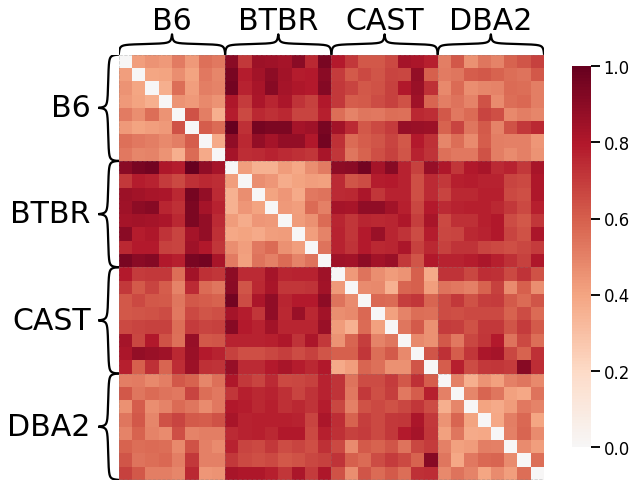

In [11]:
# HIDE CODE
scaled_edgeweight_dissim_l1 = calculate_dissim(graphs, method="edgeweight", norm="l1", normalize=True)

ax = heatmap(scaled_edgeweight_dissim_l1, context="talk", inner_hier_labels=mice.labels)
ax.figure.set_facecolor('w')

### Edge Weights - L2 Norm

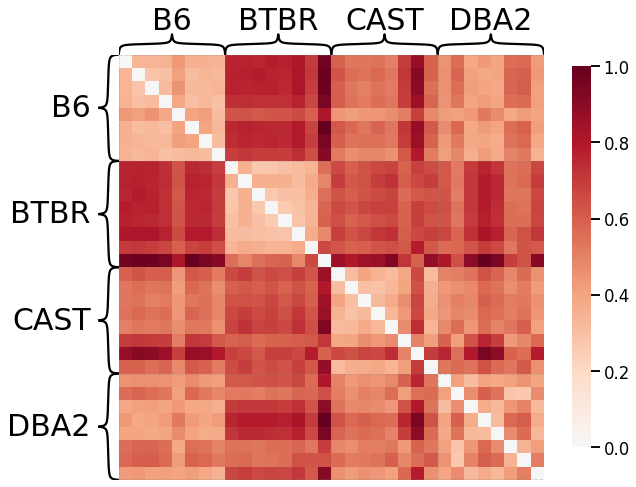

In [12]:
# HIDE CELL
scaled_edgeweight_dissim_l2 = calculate_dissim(graphs, method="edgeweight", norm="l2", normalize=True)

ax = heatmap(scaled_edgeweight_dissim_l2, context="talk", inner_hier_labels=mice.labels)
ax.figure.set_facecolor('w')

## Omnibus Embedding

Here we use omnibus embedding in order to provide a comparison to a well-established kernel.

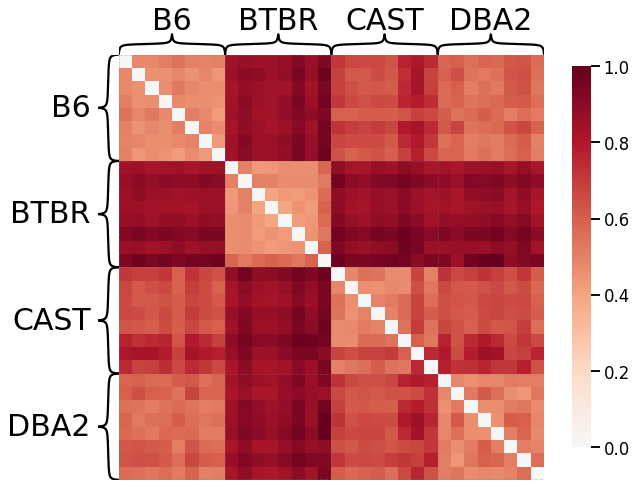

In [14]:
# HIDE CODE
from graspologic.embed import OmnibusEmbed

# embed using Omni
embedder = OmnibusEmbed(n_elbows=4)
omni_embedding = embedder.fit_transform(graphs)

# create dissimilarity matrix
omni_matrix = np.zeros((len(graphs), len(graphs)))
for i, embedding1 in enumerate(omni_embedding):
    for j, embedding2 in enumerate(omni_embedding):
        dist = np.linalg.norm(embedding1 - embedding2, ord="fro")
        omni_matrix[i, j] = dist

# plot heatmap
scaled_omni_dissim = omni_matrix / np.max(omni_matrix)

ax = heatmap(scaled_omni_dissim, context="talk", inner_hier_labels=mice.labels)
ax.figure.set_facecolor('w')

# Discriminability Plot

Here we compare the discriminability index of each kernel. Additionally, we calculate the discriminability index of a random matrix to provide a baseline for how well kernels perform compared to random chance, and its value is shown by the red dash line. The kernels are sorted by their discriminability index from highest to lowest for easy comparison. 

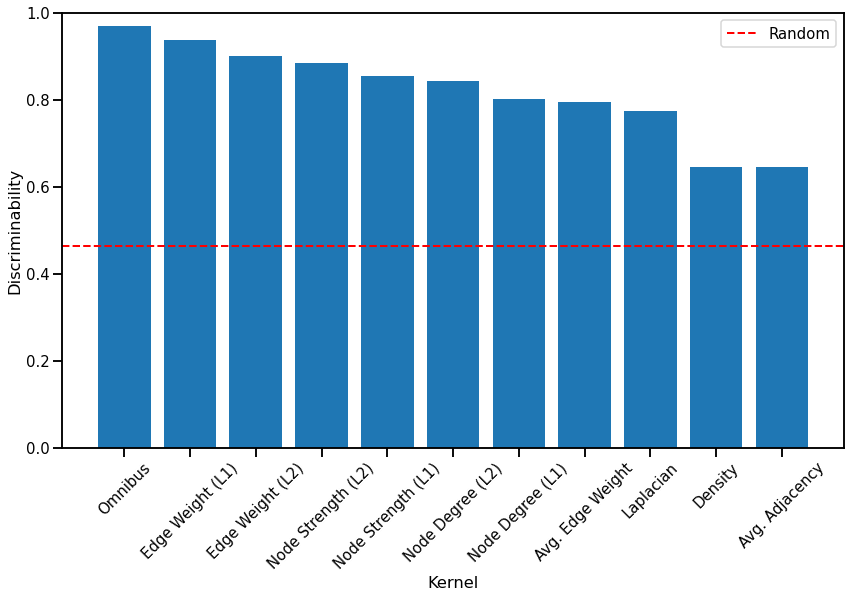

In [20]:
# HIDE CODE

from hyppo.discrim import DiscrimOneSample
discrim = DiscrimOneSample()

# construct labels
mapper = {'B6': 0, 'BTBR': 1, 'CAST': 2, 'DBA2': 3}
y = np.array([mapper[l] for l in list(mice.labels)])

# construct random matrix with zero diagonal
np.random.seed(3)
scaled_random = np.random.rand(len(graphs), len(graphs))
np.fill_diagonal(scaled_random, 0)

# calculate discriminability for each kernel matrix
discrim_omni = discrim.statistic(scaled_omni_dissim, y)
discrim_density = discrim.statistic(scaled_density_dissim, y)
discrim_avgedgeweight = discrim.statistic(scaled_avgedgeweight_dissim, y)
discrim_avgadjmat = discrim.statistic(scaled_avgadjmat_dissim, y)
discrim_lap = discrim.statistic(scaled_lap_dissim, y)
discrim_nodedeg_l1 = discrim.statistic(scaled_nodedeg_dissim_l1, y)
discrim_nodedeg_l2 = discrim.statistic(scaled_nodedeg_dissim_l2, y)
discrim_nodestr_l1 = discrim.statistic(scaled_nodestr_dissim_l1, y)
discrim_nodestr_l2 = discrim.statistic(scaled_nodestr_dissim_l2, y)
discrim_edgeweight_l1 = discrim.statistic(scaled_edgeweight_dissim_l1, y)
discrim_edgeweight_l2 = discrim.statistic(scaled_edgeweight_dissim_l2, y)
discrim_random = discrim.statistic(scaled_random, y)

# plot bar graph in descending order
kernels = ['Omnibus', 'Density', 'Avg. Edge Weight', 'Avg. Adjacency', 'Laplacian', 'Node Degree (L1)', 'Node Degree (L2)', \
    'Node Strength (L1)', 'Node Strength (L2)', 'Edge Weight (L1)', 'Edge Weight (L2)']
stats = [discrim_omni, discrim_density, discrim_avgedgeweight, discrim_avgadjmat, discrim_lap, discrim_nodedeg_l1, discrim_nodedeg_l2, \
    discrim_nodestr_l1, discrim_nodestr_l2, discrim_edgeweight_l1, discrim_edgeweight_l2]

discrim_dict = {}
for i, kernel in enumerate(kernels):
    discrim_dict[kernel] = stats[i]

sorted_discrim_dict = dict(sorted(discrim_dict.items(), key=lambda x:x[1], reverse=True))

mice_discrim_fig, ax = plt.subplots(figsize=(14,8), facecolor='w')
sns.set_context("talk", font_scale=0.9)
plt.bar(list(sorted_discrim_dict.keys()), list(sorted_discrim_dict.values()))
plt.axhline(y=discrim_random, color='r', linestyle='--', linewidth=2, label='Random')
plt.xticks(rotation=45, horizontalalignment='center')
plt.ylim([0, 1.0])
plt.xlabel('Kernel')
plt.ylabel('Discriminability')
plt.legend()

glue("mice_discrim", mice_discrim_fig, display=False)

```{glue:figure} mice_discrim_fig
:name: "mice-discrim"

Bar graph comparing the discriminability index of each kernel, sorted from highest to lowest. All kernels perform better than random chance. 
```

We observe that the Omnibus embedding kernel performs the best as expected, but surprisingly, the node-wise kernels perform better than the Laplacian spectral kernel, with the Edge weight ($L^1$-norm) kernel performing almost as well as the Omnibus embedding kernel. Kernels based on global properties of the network that do not use the known matching between the networks (Average edge weight, Laplacian spectral distance, Density, and Average of the adjacency matrix) all perform worse than node-wise and edge-wise kernels that take advantage of the matched nodes. All simple kernels took much less time to run than the Omnibus embedding kernel and the Laplacian spectral kernel.

# References
```{bibliography}
:filter: docname in docnames
:style: unsrt
```